# **Keyword Extraction from Text Reports using Fine-Tuned BERT**

In [ ]:
# Installing the required packages.

!pip install pytorch_pretrained_bert
!pip install seqeval
!pip install PyPDF2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset Paths.

tr1 = '/content/drive/MyDrive/TR_Jan22.pdf'
tr2 = '/content/drive/MyDrive/TR_Oct21.pdf'
%cp -av '/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train' '/content/'
%cp -av '/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-test' '/content/'
train_path = 'maui-semeval2010-train'
test_path = 'maui-semeval2010-test'

'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-42.key' -> '/content/maui-semeval2010-train/C-42.key'
'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-41.txt' -> '/content/maui-semeval2010-train/C-41.txt'
'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-41.key' -> '/content/maui-semeval2010-train/C-41.key'
'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-42.txt' -> '/content/maui-semeval2010-train/C-42.txt'
'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-44.key' -> '/content/maui-semeval2010-train/C-44.key'
'/content/drive/MyDrive/BERT_Keyword_Extraction.zip (Unzipped Files)/BERT_Keyword_Extraction/maui-semeval2010-train/C-44.txt' -> '/content/m

In [ ]:
# Importing the required libraries.

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import os
import argparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm, trange
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seqeval.metrics import f1_score
from itertools import chain
import PyPDF2
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Reading a Cyber Threat Report in PDF format.

pdfFileObj = open(tr1, 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
print(pdfReader.numPages)
doc1 = ''
for i in range(pdfReader.numPages):
  pageObj = pdfReader.getPage(i)
  pageStr = pageObj.extractText()
  doc1 = doc1 + pageStr
  
print(doc1)

20
ADVANCED 
THREAT
RESEARCH
REPORT
JAN 2022
REPORT
 0
3
  
LETTE R FRO M OUR CHI E F SCI ENTIST
 0
4
 
 
LOG4J
0
4
  
Log4j: The Memory That Knew Too Much 
04
   
Log4j Ti meline
05
   
Log4j Attack 
05
  
Trel li x ATR Log4j Defenses
 
06
  
RANSOMWARE
07
   
Government Response to Ransomware Threats 
07
  
Ransomware Family Detections
 
08
 
ATTACK  PATTE RN  TECHNIQUES
 
08
  
APT Threat Actors
09
  
APT  Tools
 
10
 
ADVANCED THR EAT R ESEARCH
10
  
ATR Tool Threats
 
11
  
THR EATS TO COUNTRI ES, CONTINENTS, SECTO RS AND VECTO RS
11
   
Countries & Continents: Q3 2021
11
   
Attack Sectors: Q3 2021
11
   
Attack Vectors: Q3 2021
 
12
 
LIVING OFF THE LAND: Q3 2 021
12
   
Native OS binaries
13
  
Administrative  tools
 
1
3
 
BUG REPORT
13
   
Bugs on the Windsh ield 
14
  
A Moment of Reflection
14
  
Termites
 
15
  
ADDITIONAL ATR Q3 2 021 DATA AND R ESEARCH
15
   
Ransomware: Customer Sectors , Client Countries , and MITRE 
ATT&CK Techniques
16
   
Attack Pattern Techniques (

## Data Preprocessing

In [ ]:
# Expanding abbreviations for better semantic deductions.

limits= {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "can not",
"cannot":" can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"dont":"do not" , 
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"other's":"others",
"she’s": "she is",
"can’t": "can not"
}

In [ ]:
# BERT Tokenization.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tag2idx = {'B': 0, 'I': 1, 'O': 2}
tags_vals = ['B', 'I', 'O']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

def keywordextract(sentence):
    text = sentence
    tkns = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tkns)
    segments_ids = [0] * len(tkns)
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)
    model.eval()
    prediction = []
    logit = model(tokens_tensor, token_type_ids=None,
                                  attention_mask=segments_tensors)
    logit = logit.detach().cpu().numpy()
    prediction.extend([list(p) for p in np.argmax(logit, axis=2)])
    for k, j in enumerate(prediction[0]):
        if j==1 or j==0:
            print(tokenizer.convert_ids_to_tokens(tokens_tensor[0].to('cpu').numpy())[k], j)

In [ ]:
# Obtaining keywords from text documents.

txt = sorted([f for f in os.listdir(train_path) if not f.endswith("-justTitle.txt") and not f.endswith(".key") and not f.endswith("-CrowdCountskey")])
key = sorted([f for f in os.listdir(train_path) if f.endswith(".key")])

filekey = dict()
for i, k in enumerate(txt):
    filekey[key[i]] = k

def convert(key):
    sentences = ""
    for line in open(train_path + "/" + filekey[key], 'r'):
        sentences += (" " + line.rstrip())
    tokens = sent_tokenize(sentences)
    key_file = open(train_path + "/" + str(key),'r')
    keys = [line.strip() for line in key_file]
    key_sent = []
    labels = []
    for token in tokens:
        for word in token.split():
            if word.lower() in limits:
                token = token.replace(word, limits[word.lower()])
        punctuations = '''!()-[]{};:\,<>'"./?@#$%^&*_~'''
        no_punct = ""
        for char in token:
            if char not in punctuations:
                no_punct = no_punct + char
        token=no_punct
        z = ['O'] * len(token.split())
        for k in keys:
            if k in token.lower():
                if len(k.split())==1:
                    try:                        
                        z[token.lower().split().index(k.lower().split()[0])] = 'B'
                    except ValueError:
                        continue
                elif len(k.split())>1:
                    try:
                        h = k.split()
                        def index(arr, num):
                            a = []
                            for i, x in enumerate(arr):
                                if x == num:
                                    a.append(i)
                            return(a)
                        lis1 = index(token.lower().split(),k.lower().split()[0])
                        lis2 =  index(token.lower().split(),k.lower().split()[1])
                        x = []
                        for i in lis1:
                            for j in lis2:
                                if abs(i - j) == 1:
                                    x.append(i)
                        num = x[0]  
                        z[num] = 'B'
                        for j in range(1, len(h)):
                            z[num + j] = 'I'
                    except:
                        continue
            elif k.lower().split()[0] in token.lower():
                    try:
                        h = k.split()
                        def index(arr, num):
                            a = []
                            for i, x in enumerate(arr):
                                if x == num:
                                    a.append(i)
                            return(a)
                        lis1 = index(token.lower().split(),k.lower().split()[0])
                        lis2 =  index(token.lower().split(),k.lower().split()[1])
                        x = []
                        for i in lis1:
                            for j in lis2:
                                if abs(i - j) == 1:
                                    x.append(i)
                        num = x[0]  
                        z[num] = 'B'
                        p= len(h)-1
                        y=0
                        for j in range(1,len(token.split())):
                            if (k.lower().split()[j] in token.lower().split()):
                                print(j)
                                z[num + j] = 'I'
                                print(k.lower().split()[j])
                                y+=1
                                if y==p:
                                  break
                            else:
                                continue
                    except:
                        continue      
        for m, n in enumerate(z):
            if z[m] == 'I' and z[m-1] == 'O':
                z[m] = 'O'
        if set(z) != {'O'}:
            labels.append(z) 
            key_sent.append(token)
    return key_sent, labels

sentences_ = []
labels_ = []
for key, value in filekey.items():
    s, l = convert(key)
    sentences_.append(s)
    labels_.append(l)
sentences = [item for sublist in sentences_ for item in sublist]
labels = [item for sublist in labels_ for item in sublist]

1
control
1
of
1
control
1
of
1
control
1
resource
2
management
1
grid
1
grid
3
environment
1
grid
1
grid
1
gridway
1
grid
1
grid
1
sensor
1
sequence
1
sensor
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
2
process
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
sequence
1
of
1
index
1
of
1
index
1
of
1
index
1
index
1
index
2
structure
1
skip
1
index
1
of
1
index
1
range
1
range
1
range
2
query
1
range
1
range
1
range
1
range
1
storage
1
range
1
range
1
storage
1
range
1
range
1
range
1
range
1
storage
1
range
1
range
1
storage
1
storage
1
mobility
1
of
1
of
2
past
4
and
5
transitivity
1
tracking
1
tracking
1
tracking
1
tracking
1
tracking
1
and
1
tracking
1
and
1


In [ ]:
# Generating Input IDs and Attention Masks.

MAX_LEN = 75
bs = 32
tag2idx = {'B': 0, 'I': 1, 'O': 2}
tags_vals = ['B', 'I', 'O']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (679 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (543 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (606 > 512). Running this sequence through BERT will result in indexing errors


## Training and Validation Split

In [ ]:
# DataLoaders for the Training and Validation Sets.

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

## BERT Base Uncased Model

In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))
model = model.cuda()
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
      

## Fine-Tuning BERT for Keyword Extraction

In [ ]:
# Fine-tuning BERT model for Keyword Extraction.

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
# Function to find the Accuracy of the model.

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Training and Evaluation

In [ ]:
# Training and Evaluation of BERT on the SemEval Dataset.

epochs = 4
max_grad_norm = 1.0
train_loss_list = []
valid_loss_list = []
valid_acc_list = []

for _ in trange(epochs, desc="Epoch"):
    # Training.
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        loss.backward()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        model.zero_grad()
        train_loss_list.append(tr_loss/nb_tr_steps)
    print()
    print("Training Loss: {}".format(tr_loss/nb_tr_steps))
    # Validation.
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
        valid_acc_list.append(eval_accuracy/nb_eval_steps)
        valid_loss_list.append(eval_loss/nb_eval_steps)
    eval_loss = eval_loss/nb_eval_steps
    pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
    valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
    print()
    print("Validation Loss: {}".format(eval_loss/nb_eval_steps))
    print()
    print("Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print()
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


Training Loss: 0.05743581908962207

Validation Loss: 0.0020001793341685296

Accuracy: 0.9668894675925924



Epoch:  25%|██▌       | 1/4 [02:18<06:55, 138.52s/it]

F1-Score: 0.42296918767507


Training Loss: 0.04882449025519419

Validation Loss: 0.002101011921897427

Accuracy: 0.9614959490740741



Epoch:  50%|█████     | 2/4 [04:36<04:36, 138.29s/it]

F1-Score: 0.40685920577617324


Training Loss: 0.04186555641578986

Validation Loss: 0.00235357524393799

Accuracy: 0.9592274305555556



Epoch:  75%|███████▌  | 3/4 [06:54<02:18, 138.22s/it]

F1-Score: 0.4023430962343097


Training Loss: 0.035885343929006774

Validation Loss: 0.002276943099180547

Accuracy: 0.9611950231481483



Epoch: 100%|██████████| 4/4 [09:12<00:00, 138.24s/it]

F1-Score: 0.43774140150818464



In [ ]:
loss_list = [train_loss_list, valid_loss_list]
loss_df = pd.DataFrame (loss_list).transpose()
loss_df.columns = ['train_loss', 'valid_loss']
valid_acc = pd.DataFrame(valid_acc_list, columns=['valid_acc'])

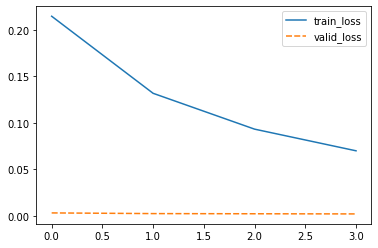

In [ ]:
sns.lineplot(data=loss_df).set(title='Training Loss and Validation Loss')

[Text(0.5, 1.0, 'Accuracy')]

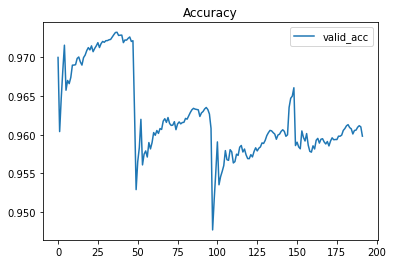

In [ ]:
sns.lineplot(data=valid_acc).set(title='Accuracy')

In [ ]:
y_true = list(chain.from_iterable(valid_tags))
y_pred = list(chain.from_iterable(pred_tags))

[[  1313     76    297]
 [    22    759    213]
 [  2035   1739 107246]]


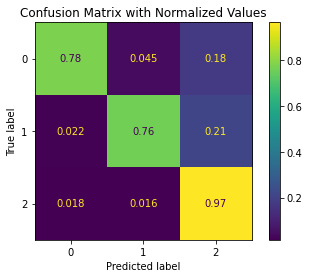

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp = disp.plot()
plt.title("Confusion Matrix with Normalized Values")
plt.show()

## Testing

In [ ]:
text = 'Wireless Sensor Networks have been proposed for use in many location dependent applications.'

In [ ]:
keywordextract(text)

wireless 0
sensor 1
networks 1
location 0
dependent 1
applications 1


In [ ]:
text2 = 'Most of these need to identify the locations of wireless sensor nodes, a challenging task because of the severe constraints on cost, energy and effective range of sensor devices.'

In [ ]:
keywordextract(text2)

wireless 0
sensor 1
range 0


In [ ]:
text3 = 'To overcome limitations in existing solutions, we present a Multi Sequence Positioning method for large scale stationary sensor node localization in outdoor environments.'

In [ ]:
keywordextract(text3)

sensor 1
node 1
local 0
